# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Fri Mar 20 15:37:51 2020


In [2]:
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.models.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder
import src.train.train_model
%config IPCompleter.greedy=True
%reload_ext autoreload


In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [8]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
128


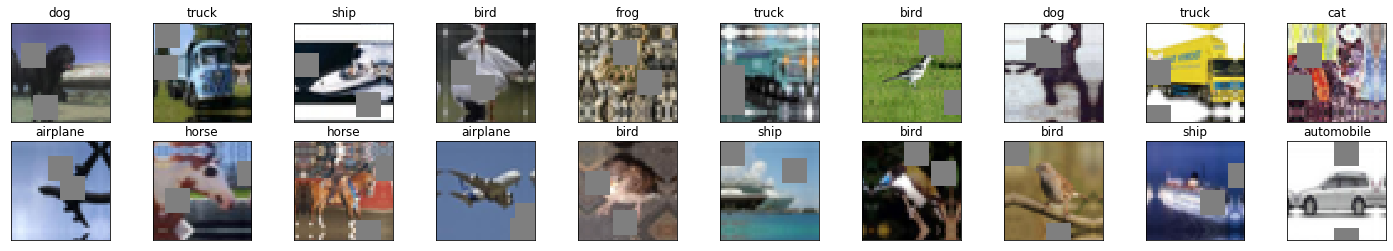

In [10]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [18]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.08, momentum=0.9, weight_decay=0)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.5, patience=2,
                                        verbose=True)
criterion = torch.nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


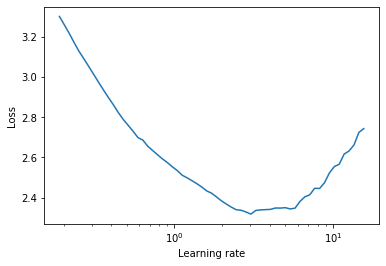

In [14]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()

In [19]:
lr_finder.reset()

In [16]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


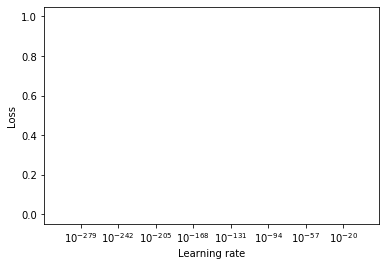

In [17]:
lr_finder.plot(skip_end=0)

In [23]:
lr_finder.reset()

In [24]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.085, momentum=0.9, weight_decay=0)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [25]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 50
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(cnn_model, device, test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.5989936590194702 Batch_id=781 Accuracy=35.43: 100%|██████████| 782/782 [02:58<00:00,  4.39it/s]



Test set: Average loss: 0.0429, Accuracy: 2780/10000 (27.80%)

Validation accuracy increased (0.000000 --> 27.800000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  2
EPOCH: 2


Loss=1.0172394514083862 Batch_id=781 Accuracy=49.68: 100%|██████████| 782/782 [03:22<00:00,  3.85it/s]



Test set: Average loss: 0.0345, Accuracy: 4045/10000 (40.45%)

Validation accuracy increased (27.800000 --> 40.450000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  3
EPOCH: 3


Loss=1.1451752185821533 Batch_id=781 Accuracy=57.16: 100%|██████████| 782/782 [03:21<00:00,  3.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 3749/10000 (37.49%)

Learning rate = 0.085  for epoch:  4
EPOCH: 4


Loss=1.088819980621338 Batch_id=781 Accuracy=62.79: 100%|██████████| 782/782 [03:20<00:00,  3.90it/s] 



Test set: Average loss: 0.0350, Accuracy: 4419/10000 (44.19%)

Validation accuracy increased (40.450000 --> 44.190000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  5
EPOCH: 5


Loss=0.5732927322387695 Batch_id=781 Accuracy=67.93: 100%|██████████| 782/782 [03:21<00:00,  3.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 4006/10000 (40.06%)

Learning rate = 0.085  for epoch:  6
EPOCH: 6


Loss=0.7024797201156616 Batch_id=781 Accuracy=71.82: 100%|██████████| 782/782 [03:22<00:00,  3.86it/s] 



Test set: Average loss: 0.0351, Accuracy: 4842/10000 (48.42%)

Validation accuracy increased (44.190000 --> 48.420000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  7
EPOCH: 7


Loss=0.8439047932624817 Batch_id=781 Accuracy=75.32: 100%|██████████| 782/782 [03:19<00:00,  3.92it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 4683/10000 (46.83%)

Learning rate = 0.085  for epoch:  8
EPOCH: 8


Loss=0.6338827610015869 Batch_id=781 Accuracy=77.67: 100%|██████████| 782/782 [03:18<00:00,  3.94it/s] 



Test set: Average loss: 0.0288, Accuracy: 5567/10000 (55.67%)

Validation accuracy increased (48.420000 --> 55.670000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  9
EPOCH: 9


Loss=0.24332313239574432 Batch_id=781 Accuracy=80.01: 100%|██████████| 782/782 [03:18<00:00,  3.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 5371/10000 (53.71%)

Learning rate = 0.085  for epoch:  10
EPOCH: 10


Loss=0.23142535984516144 Batch_id=781 Accuracy=82.03: 100%|██████████| 782/782 [03:20<00:00,  3.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 5455/10000 (54.55%)

Learning rate = 0.085  for epoch:  11
EPOCH: 11


Loss=0.2333793044090271 Batch_id=781 Accuracy=84.06: 100%|██████████| 782/782 [03:22<00:00,  3.87it/s] 



Test set: Average loss: 0.0225, Accuracy: 6402/10000 (64.02%)

Validation accuracy increased (55.670000 --> 64.020000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  12
EPOCH: 12


Loss=0.17406776547431946 Batch_id=781 Accuracy=85.34: 100%|██████████| 782/782 [03:15<00:00,  4.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 5914/10000 (59.14%)

Learning rate = 0.085  for epoch:  13
EPOCH: 13


Loss=0.5029281973838806 Batch_id=781 Accuracy=86.81: 100%|██████████| 782/782 [03:16<00:00,  3.98it/s] 



Test set: Average loss: 0.0253, Accuracy: 6476/10000 (64.76%)

Validation accuracy increased (64.020000 --> 64.760000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  14
EPOCH: 14


Loss=0.5592832565307617 Batch_id=781 Accuracy=88.31: 100%|██████████| 782/782 [03:18<00:00,  3.93it/s] 



Test set: Average loss: 0.0250, Accuracy: 6701/10000 (67.01%)

Validation accuracy increased (64.760000 --> 67.010000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.085  for epoch:  15
EPOCH: 15


Loss=0.1596589982509613 Batch_id=781 Accuracy=89.71: 100%|██████████| 782/782 [03:14<00:00,  4.01it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 6553/10000 (65.53%)

Learning rate = 0.085  for epoch:  16
EPOCH: 16


Loss=0.21525885164737701 Batch_id=781 Accuracy=90.89: 100%|██████████| 782/782 [03:16<00:00,  3.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 6365/10000 (63.65%)

Learning rate = 0.085  for epoch:  17
EPOCH: 17


Loss=0.3419971764087677 Batch_id=781 Accuracy=91.67: 100%|██████████| 782/782 [03:18<00:00,  3.95it/s]  



Test set: Average loss: 0.0250, Accuracy: 6710/10000 (67.10%)

Validation accuracy increased (67.010000 --> 67.100000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 7.6500e-02.
Learning rate = 0.07650000000000001  for epoch:  18
EPOCH: 18


Loss=0.2549881637096405 Batch_id=781 Accuracy=93.00: 100%|██████████| 782/782 [03:08<00:00,  4.16it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 6518/10000 (65.18%)

Learning rate = 0.07650000000000001  for epoch:  19
EPOCH: 19


Loss=0.010909795761108398 Batch_id=781 Accuracy=93.78: 100%|██████████| 782/782 [03:00<00:00,  4.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 6594/10000 (65.94%)

Learning rate = 0.07650000000000001  for epoch:  20
EPOCH: 20


Loss=0.3567797541618347 Batch_id=781 Accuracy=94.41: 100%|██████████| 782/782 [03:00<00:00,  4.33it/s]  



Test set: Average loss: 0.0256, Accuracy: 6885/10000 (68.85%)

Validation accuracy increased (67.100000 --> 68.850000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.07650000000000001  for epoch:  21
EPOCH: 21


Loss=0.30489808320999146 Batch_id=781 Accuracy=94.99: 100%|██████████| 782/782 [02:58<00:00,  4.37it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 6812/10000 (68.12%)

Learning rate = 0.07650000000000001  for epoch:  22
EPOCH: 22


Loss=0.008523315191268921 Batch_id=781 Accuracy=95.52: 100%|██████████| 782/782 [03:01<00:00,  4.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 6592/10000 (65.92%)

Learning rate = 0.07650000000000001  for epoch:  23
EPOCH: 23


Loss=0.13682067394256592 Batch_id=781 Accuracy=95.91: 100%|██████████| 782/782 [03:00<00:00,  4.33it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 6799/10000 (67.99%)

Epoch    23: reducing learning rate of group 0 to 6.8850e-02.
Learning rate = 0.06885000000000001  for epoch:  24
EPOCH: 24


Loss=0.015225082635879517 Batch_id=781 Accuracy=96.77: 100%|██████████| 782/782 [03:01<00:00,  4.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 6706/10000 (67.06%)

Learning rate = 0.06885000000000001  for epoch:  25
EPOCH: 25


Loss=0.07923874258995056 Batch_id=781 Accuracy=96.88: 100%|██████████| 782/782 [03:02<00:00,  4.30it/s] 



Test set: Average loss: 0.0259, Accuracy: 7030/10000 (70.30%)

Validation accuracy increased (68.850000 --> 70.300000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06885000000000001  for epoch:  26
EPOCH: 26


Loss=0.030627161264419556 Batch_id=781 Accuracy=97.10: 100%|██████████| 782/782 [03:02<00:00,  4.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 6823/10000 (68.23%)

Learning rate = 0.06885000000000001  for epoch:  27
EPOCH: 27


Loss=0.2027125060558319 Batch_id=781 Accuracy=97.15: 100%|██████████| 782/782 [03:02<00:00,  4.29it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 6868/10000 (68.68%)

Learning rate = 0.06885000000000001  for epoch:  28
EPOCH: 28


Loss=0.007557988166809082 Batch_id=781 Accuracy=97.48: 100%|██████████| 782/782 [02:59<00:00,  4.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 7014/10000 (70.14%)

Epoch    28: reducing learning rate of group 0 to 6.1965e-02.
Learning rate = 0.061965000000000006  for epoch:  29
EPOCH: 29


Loss=0.00537484884262085 Batch_id=781 Accuracy=97.74: 100%|██████████| 782/782 [03:03<00:00,  4.27it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 6975/10000 (69.75%)

Learning rate = 0.061965000000000006  for epoch:  30
EPOCH: 30


Loss=0.05153095722198486 Batch_id=781 Accuracy=97.86: 100%|██████████| 782/782 [03:02<00:00,  4.29it/s]  



Test set: Average loss: 0.0262, Accuracy: 7131/10000 (71.31%)

Validation accuracy increased (70.300000 --> 71.310000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.061965000000000006  for epoch:  31
EPOCH: 31


Loss=0.014883935451507568 Batch_id=781 Accuracy=98.08: 100%|██████████| 782/782 [02:59<00:00,  4.36it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 6937/10000 (69.37%)

Learning rate = 0.061965000000000006  for epoch:  32
EPOCH: 32


Loss=0.07411575317382812 Batch_id=781 Accuracy=98.21: 100%|██████████| 782/782 [03:00<00:00,  4.33it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 7091/10000 (70.91%)

Learning rate = 0.061965000000000006  for epoch:  33
EPOCH: 33


Loss=0.08137723803520203 Batch_id=781 Accuracy=98.32: 100%|██████████| 782/782 [03:01<00:00,  4.32it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 7107/10000 (71.07%)

Epoch    33: reducing learning rate of group 0 to 5.5769e-02.
Learning rate = 0.055768500000000006  for epoch:  34
EPOCH: 34


Loss=0.02189701795578003 Batch_id=781 Accuracy=98.51: 100%|██████████| 782/782 [02:59<00:00,  4.37it/s]  



Test set: Average loss: 0.0265, Accuracy: 7275/10000 (72.75%)

Validation accuracy increased (71.310000 --> 72.750000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.055768500000000006  for epoch:  35
EPOCH: 35


Loss=0.03438770771026611 Batch_id=781 Accuracy=98.72: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 7249/10000 (72.49%)

Learning rate = 0.055768500000000006  for epoch:  36
EPOCH: 36


Loss=0.05612170696258545 Batch_id=781 Accuracy=98.76: 100%|██████████| 782/782 [03:01<00:00,  4.31it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 7187/10000 (71.87%)

Learning rate = 0.055768500000000006  for epoch:  37
EPOCH: 37


Loss=0.10545933246612549 Batch_id=781 Accuracy=98.81: 100%|██████████| 782/782 [03:01<00:00,  4.32it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 7224/10000 (72.24%)

Epoch    37: reducing learning rate of group 0 to 5.0192e-02.
Learning rate = 0.050191650000000004  for epoch:  38
EPOCH: 38


Loss=0.014727354049682617 Batch_id=781 Accuracy=98.84: 100%|██████████| 782/782 [03:01<00:00,  4.31it/s] 



Test set: Average loss: 0.0256, Accuracy: 7364/10000 (73.64%)

Validation accuracy increased (72.750000 --> 73.640000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.050191650000000004  for epoch:  39
EPOCH: 39


Loss=0.03157868981361389 Batch_id=781 Accuracy=98.94: 100%|██████████| 782/782 [02:57<00:00,  4.40it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 7226/10000 (72.26%)

Learning rate = 0.050191650000000004  for epoch:  40
EPOCH: 40


Loss=0.02188292145729065 Batch_id=781 Accuracy=99.11: 100%|██████████| 782/782 [03:00<00:00,  4.32it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 7315/10000 (73.15%)

Learning rate = 0.050191650000000004  for epoch:  41
EPOCH: 41


Loss=0.0011751055717468262 Batch_id=781 Accuracy=99.02: 100%|██████████| 782/782 [03:00<00:00,  4.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 7150/10000 (71.50%)

Epoch    41: reducing learning rate of group 0 to 4.5172e-02.
Learning rate = 0.045172485000000005  for epoch:  42
EPOCH: 42


Loss=0.001673877239227295 Batch_id=781 Accuracy=99.33: 100%|██████████| 782/782 [02:58<00:00,  4.38it/s] 



Test set: Average loss: 0.0272, Accuracy: 7378/10000 (73.78%)

Validation accuracy increased (73.640000 --> 73.780000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.045172485000000005  for epoch:  43
EPOCH: 43


Loss=0.0015360116958618164 Batch_id=781 Accuracy=99.21: 100%|██████████| 782/782 [02:58<00:00,  4.39it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 7221/10000 (72.21%)

Learning rate = 0.045172485000000005  for epoch:  44
EPOCH: 44


Loss=0.011072635650634766 Batch_id=781 Accuracy=99.32: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 7305/10000 (73.05%)

Epoch    44: reducing learning rate of group 0 to 4.0655e-02.
Learning rate = 0.040655236500000004  for epoch:  45
EPOCH: 45


Loss=0.0011085271835327148 Batch_id=781 Accuracy=99.35: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 7292/10000 (72.92%)

Learning rate = 0.040655236500000004  for epoch:  46
EPOCH: 46


Loss=0.002037346363067627 Batch_id=781 Accuracy=99.44: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 7309/10000 (73.09%)

Learning rate = 0.040655236500000004  for epoch:  47
EPOCH: 47


Loss=0.04599565267562866 Batch_id=781 Accuracy=99.52: 100%|██████████| 782/782 [02:57<00:00,  4.40it/s]   



Test set: Average loss: 0.0278, Accuracy: 7402/10000 (74.02%)

Validation accuracy increased (73.780000 --> 74.020000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    47: reducing learning rate of group 0 to 3.6590e-02.
Learning rate = 0.036589712850000004  for epoch:  48
EPOCH: 48


Loss=5.6624412536621094e-05 Batch_id=781 Accuracy=99.57: 100%|██████████| 782/782 [02:58<00:00,  4.38it/s]



Test set: Average loss: 0.0276, Accuracy: 7435/10000 (74.35%)

Validation accuracy increased (74.020000 --> 74.350000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.036589712850000004  for epoch:  49
EPOCH: 49


Loss=0.027366340160369873 Batch_id=781 Accuracy=99.54: 100%|██████████| 782/782 [03:00<00:00,  4.33it/s]  



Test set: Average loss: 0.0265, Accuracy: 7538/10000 (75.38%)

Validation accuracy increased (74.350000 --> 75.380000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.036589712850000004  for epoch:  50
EPOCH: 50


Loss=0.0019524693489074707 Batch_id=781 Accuracy=99.57: 100%|██████████| 782/782 [02:58<00:00,  4.37it/s] 



Test set: Average loss: 0.0270, Accuracy: 7460/10000 (74.60%)

Learning rate = 0.036589712850000004  for epoch:  51


In [ ]:
import numpy as np
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# obtain one batch of test images
dataiterator = iter(test_loader)
plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=cnn_model,classes=classes,
                                          batch_size=batch_size)

In [ ]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data)

In [ ]:
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses)

In [ ]:
import torch
import src.utils.utils as utils
print(torch.cuda.is_available())
saved_data = utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

In [ ]:
model, device = utils.Utils.createmodelresnet18()
model.load_state_dict(state_dict=saved_data['model_state_dict'])

In [ ]:
import glob
from PIL import Image
from src.utils.modelutils import ModelUtils

image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
ModelUtils.subplot(images, title='inputs', nrows=2, ncols=5)

In [ ]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

In [ ]:
from src.visualization.gradcam.gradcam import gradcamof

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

gradcamof(model,inputs,classes)